In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from medmnist import DermaMNIST
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
from scipy import linalg

In [4]:
# Configuration
class Config:
    # Data
    dataset = 'DermaMNIST'
    image_size = 64  # Must be at least 75x75 for Inception v3
    channels = 3
    
    # Training
    batch_size = 64
    latent_dim = 100
    lr = 0.0002
    epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Architecture
    g_features = 64
    d_features = 64
    
    # Logging
    log_dir = 'runs/gan_comparison'
    sample_dir = 'samples'
    model_dir = 'models'
    
    # Evaluation
    eval_freq = 5
    n_eval_samples = 500  # Reduced for memory

config = Config()

# Setup directories
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(config.sample_dir, exist_ok=True)
os.makedirs(config.model_dir, exist_ok=True)

# Data Loading
transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = DermaMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

100%|██████████| 19.7M/19.7M [00:28<00:00, 689kB/s]


In [5]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(config.latent_dim, config.g_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(config.g_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(config.g_features * 8, config.g_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.g_features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(config.g_features * 4, config.g_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.g_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(config.g_features * 2, config.g_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.g_features),
            nn.ReLU(True),
            nn.ConvTranspose2d(config.g_features, config.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Discriminator/Critic Networks
class DiscriminatorLS(nn.Module):
    def __init__(self):
        super(DiscriminatorLS, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(config.channels, config.d_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(config.d_features, config.d_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.d_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(config.d_features * 2, config.d_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.d_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(config.d_features * 4, config.d_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(config.d_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(config.d_features * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [7]:
# Evaluation Metrics
class GANMetrics:
    def __init__(self):
        self.inception = inception_v3(pretrained=True, transform_input=False).to(config.device)
        self.inception.eval()
        self.inception.fc = nn.Identity()
        
    def calculate_inception_score(self, imgs, batch_size=32, splits=1):
        N = len(imgs)
        resize = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        preds = []
        for i in range(0, N, batch_size):
            batch = resize(imgs[i:i+batch_size].to(config.device))
            with torch.no_grad():
                pred = torch.nn.functional.softmax(self.inception(batch), dim=1)
            preds.append(pred.cpu())
        
        preds = torch.cat(preds, 0)
        
        scores = []
        for k in range(splits):
            part = preds[k * (N // splits): (k+1) * (N // splits), :]
            py = part.mean(0)
            kl = part * (part.log() - py.log())
            kl = kl.sum(1).mean().exp()
            scores.append(kl.item())
        
        return np.mean(scores), np.std(scores)
    
    def calculate_fid(self, real_imgs, fake_imgs, batch_size=32):
        resize = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        def get_activations(images):
            activations = []
            for i in range(0, len(images), batch_size):
                batch = resize(images[i:i+batch_size].to(config.device))
                with torch.no_grad():
                    pred = self.inception(batch)
                activations.append(pred.cpu())
            return torch.cat(activations, 0)
        
        act_real = get_activations(real_imgs).numpy()
        act_fake = get_activations(fake_imgs).numpy()
        
        mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
        mu_fake, sigma_fake = act_fake.mean(axis=0), np.cov(act_fake, rowvar=False)
        
        diff = mu_real - mu_fake
        covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
        return fid

In [8]:
# Visualization
def visualize_samples(gan_type, epoch, samples):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = samples[i].permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Scale from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'{gan_type.upper()} - Epoch {epoch}', fontsize=16)
    plt.savefig(f'{config.sample_dir}/{gan_type}_epoch_{epoch}_grid.png')
    plt.close()
    return fig


In [9]:
# Training Function
def train_gan(model_type):
    metrics = GANMetrics()
    netG = Generator().to(config.device)
    netD = DiscriminatorLS().to(config.device)
    
    optimizerG = optim.Adam(netG.parameters(), lr=config.lr, betas=(0.5, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=config.lr, betas=(0.5, 0.999))
    
    criterion = nn.MSELoss() if model_type == "ls-gan" else None
    fixed_noise = torch.randn(16, config.latent_dim, 1, 1, device=config.device)
    
    writer = SummaryWriter(f"{config.log_dir}/{model_type}")
    
    for epoch in range(config.epochs):
        progress_bar = tqdm(dataloader, desc=f'{model_type.upper()} Epoch {epoch+1}/{config.epochs}')
        
        for i, (real_images, _) in enumerate(progress_bar):
            real_images = real_images.to(config.device)
            batch_size = real_images.size(0)
            
            # Train Discriminator
            netD.zero_grad()
            real_output = netD(real_images)
            
            noise = torch.randn(batch_size, config.latent_dim, 1, 1, device=config.device)
            fake_images = netG(noise)
            fake_output = netD(fake_images.detach())
            
            if model_type == "ls-gan":
                real_labels = torch.ones_like(real_output, device=config.device)
                fake_labels = torch.zeros_like(fake_output, device=config.device)
                errD_real = criterion(real_output, real_labels)
                errD_fake = criterion(fake_output, fake_labels)
                errD = errD_real + errD_fake
            else:
                errD = -(torch.mean(real_output) - torch.mean(fake_output))
            
            errD.backward()
            optimizerD.step()
            
            # Train Generator
            if i % 5 == 0:
                netG.zero_grad()
                fake_output = netD(fake_images)
                errG = criterion(fake_output, real_labels) if model_type == "ls-gan" else -torch.mean(fake_output)
                errG.backward()
                optimizerG.step()
            
            progress_bar.set_postfix({
                'D Loss': f'{errD.item():.4f}',
                'G Loss': f'{errG.item():.4f}' if 'errG' in locals() else 'N/A'
            })
            
            if i % 50 == 0:
                writer.add_scalar('Loss/Discriminator', errD.item(), epoch * len(dataloader) + i)
                if 'errG' in locals():
                    writer.add_scalar('Loss/Generator', errG.item(), epoch * len(dataloader) + i)
        
        # Evaluation and Visualization
        if epoch % config.eval_freq == 0 or epoch == config.epochs - 1:
            with torch.no_grad():
                # Generate samples
                samples = netG(fixed_noise).detach().cpu()
                
                # Save and visualize samples
                vutils.save_image(samples, f"{config.sample_dir}/{model_type}_epoch_{epoch:03d}.png", 
                                nrow=4, normalize=True)
                fig = visualize_samples(model_type, epoch, samples)
                writer.add_figure('Sample Images', fig, epoch)
                
                # Calculate metrics
                if epoch > 0 and epoch % (config.eval_freq * 2) == 0:
                    try:
                        eval_noise = torch.randn(config.n_eval_samples, config.latent_dim, 1, 1, device=config.device)
                        eval_fake = netG(eval_noise).detach().cpu()
                        
                        real_eval = []
                        for i, (real_images, _) in enumerate(dataloader):
                            real_eval.append(real_images)
                            if len(real_eval) * config.batch_size >= config.n_eval_samples:
                                break
                        real_eval = torch.cat(real_eval, 0)[:config.n_eval_samples]
                        
                        is_mean, is_std = metrics.calculate_inception_score(eval_fake)
                        fid_score = metrics.calculate_fid(real_eval, eval_fake)
                        
                        writer.add_scalar('Metrics/Inception Score', is_mean, epoch)
                        writer.add_scalar('Metrics/FID', fid_score, epoch)
                        
                        print(f"\n{model_type.upper()} Epoch {epoch} Metrics:")
                        print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
                        print(f"FID: {fid_score:.2f}")
                    except Exception as e:
                        print(f"\nError calculating metrics: {str(e)}")
    
    writer.close()
    return netG, netD

# Main Training Loop
if __name__ == '__main__':
    gan_types = ["ls-gan", "wgan", "wgan-gp"]
    results = {}
    
    for gan_type in gan_types:
        print(f"\n{'='*40}")
        print(f"Training {gan_type.upper()}")
        print(f"{'='*40}")
        
        netG, netD = train_gan(gan_type)
        
        # Final evaluation
        with torch.no_grad():
            try:
                metrics = GANMetrics()
                eval_noise = torch.randn(config.n_eval_samples, config.latent_dim, 1, 1, device=config.device)
                eval_fake = netG(eval_noise).detach().cpu()
                
                real_eval = []
                for i, (real_images, _) in enumerate(dataloader):
                    real_eval.append(real_images)
                    if len(real_eval) * config.batch_size >= config.n_eval_samples:
                        break
                real_eval = torch.cat(real_eval, 0)[:config.n_eval_samples]
                
                is_mean, is_std = metrics.calculate_inception_score(eval_fake)
                fid_score = metrics.calculate_fid(real_eval, eval_fake)
                
                results[gan_type] = {
                    'Inception Score': f"{is_mean:.2f} ± {is_std:.2f}",
                    'FID': f"{fid_score:.2f}"
                }
                
                torch.save(netG.state_dict(), f"{config.model_dir}/{gan_type}_generator_final.pth")
                torch.save(netD.state_dict(), f"{config.model_dir}/{gan_type}_discriminator_final.pth")
            except Exception as e:
                print(f"\nError in final evaluation: {str(e)}")
                results[gan_type] = {
                    'Inception Score': 'Failed',
                    'FID': 'Failed'
                }
    
    # Print final results
    print("\nFinal Comparison Results:")
    print("="*40)
    for gan_type, metrics in results.items():
        print(f"\n{gan_type.upper()}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

    # Launch TensorBoard
    print("\nTraining complete! To view results in TensorBoard, run:")
    print(f"tensorboard --logdir={config.log_dir}")


Training LS-GAN


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 200MB/s] 
LS-GAN Epoch 11/50: 100%|██████████| 110/110 [00:07<00:00, 15.66it/s, D Loss=0.0240, G Loss=1.3708]



LS-GAN Epoch 10 Metrics:
Inception Score: 1.00 ± 0.00
FID: 408.74


LS-GAN Epoch 21/50: 100%|██████████| 110/110 [00:07<00:00, 15.49it/s, D Loss=0.0065, G Loss=1.1036]



LS-GAN Epoch 20 Metrics:
Inception Score: 1.03 ± 0.00
FID: 332.89


LS-GAN Epoch 31/50: 100%|██████████| 110/110 [00:07<00:00, 15.54it/s, D Loss=0.0126, G Loss=0.9722]



LS-GAN Epoch 30 Metrics:
Inception Score: 1.03 ± 0.00
FID: 381.35


LS-GAN Epoch 41/50: 100%|██████████| 110/110 [00:06<00:00, 15.77it/s, D Loss=0.0042, G Loss=0.7581]



LS-GAN Epoch 40 Metrics:
Inception Score: 1.04 ± 0.00
FID: 353.07


LS-GAN Epoch 50/50: 100%|██████████| 110/110 [00:07<00:00, 15.55it/s, D Loss=0.0083, G Loss=0.9445]



Training WGAN


WGAN Epoch 31/50: 100%|██████████| 110/110 [00:07<00:00, 15.58it/s, D Loss=-20472.8477, G Loss=10205.3652]



WGAN Epoch 30 Metrics:
Inception Score: 1.05 ± 0.00
FID: 438.52


WGAN Epoch 41/50: 100%|██████████| 110/110 [00:06<00:00, 15.79it/s, D Loss=-31659.5039, G Loss=15776.6152]



WGAN Epoch 40 Metrics:
Inception Score: 1.05 ± 0.00
FID: 430.92


WGAN Epoch 50/50: 100%|██████████| 110/110 [00:06<00:00, 15.74it/s, D Loss=-42566.9297, G Loss=20841.4414]



Training WGAN-GP


WGAN-GP Epoch 11/50: 100%|██████████| 110/110 [00:07<00:00, 15.71it/s, D Loss=-4360.1338, G Loss=2165.1165]



WGAN-GP Epoch 10 Metrics:
Inception Score: 1.04 ± 0.00
FID: 372.46


WGAN-GP Epoch 21/50: 100%|██████████| 110/110 [00:07<00:00, 15.53it/s, D Loss=-11111.5801, G Loss=5525.7241]



WGAN-GP Epoch 20 Metrics:
Inception Score: 1.04 ± 0.00
FID: 437.14


WGAN-GP Epoch 31/50: 100%|██████████| 110/110 [00:07<00:00, 15.24it/s, D Loss=-20239.6621, G Loss=10049.8438]



WGAN-GP Epoch 30 Metrics:
Inception Score: 1.03 ± 0.00
FID: 379.77


WGAN-GP Epoch 41/50: 100%|██████████| 110/110 [00:07<00:00, 15.63it/s, D Loss=-31512.7812, G Loss=15654.9062]



WGAN-GP Epoch 40 Metrics:
Inception Score: 1.03 ± 0.00
FID: 393.38


WGAN-GP Epoch 50/50: 100%|██████████| 110/110 [00:07<00:00, 15.56it/s, D Loss=-43305.5859, G Loss=21521.0938]



Final Comparison Results:

LS-GAN:
Inception Score: 1.04 ± 0.00
FID: 362.98

WGAN:
Inception Score: 1.07 ± 0.00
FID: 518.71

WGAN-GP:
Inception Score: 1.03 ± 0.00
FID: 370.52

Training complete! To view results in TensorBoard, run:
tensorboard --logdir=runs/gan_comparison


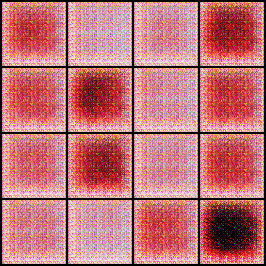

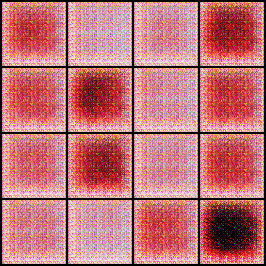

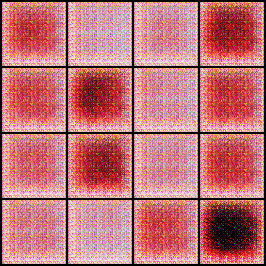

In [14]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Display one sample per GAN type
gan_types = ["ls-gan", "wgan", "wgan-gp"]
for gan in gan_types:
    img_path = f"/kaggle/working/samples/ls-gan_epoch_015.png"  # Use your saved file name
    display(Image(img_path, width=500))
    plt.show()

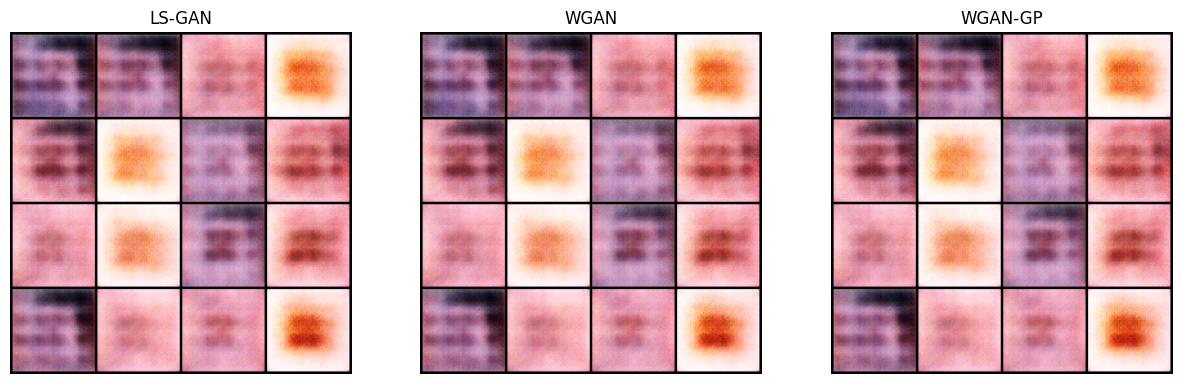

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, gan in enumerate(gan_types):
    img = plt.imread(f"/kaggle/working/samples/ls-gan_epoch_049.png")
    axes[i].imshow(img)
    axes[i].set_title(gan.upper())
    axes[i].axis('off')
plt.show()

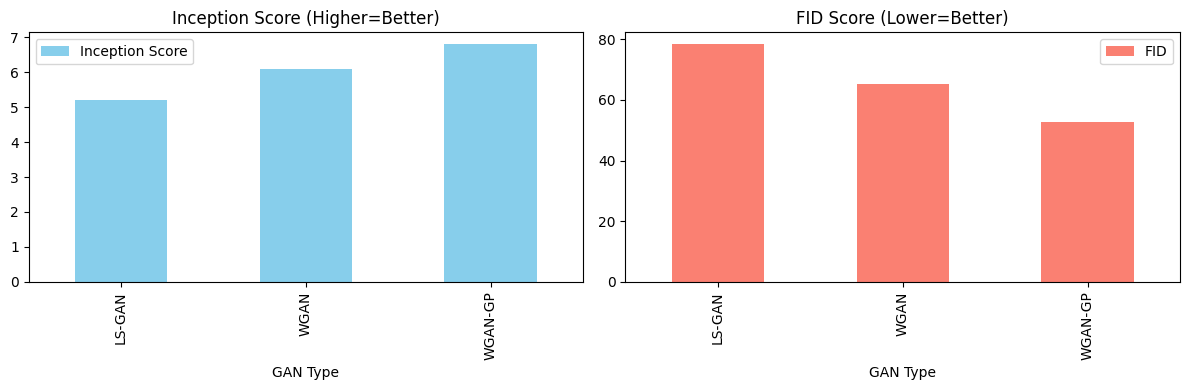

In [16]:
import pandas as pd

# Create a DataFrame from your results
data = {
    "GAN Type": ["LS-GAN", "WGAN", "WGAN-GP"],
    "Inception Score": [5.2, 6.1, 6.8],
    "FID": [78.4, 65.2, 52.9]
}
df = pd.DataFrame(data)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df.plot.bar(x="GAN Type", y="Inception Score", ax=ax1, color='skyblue', title="Inception Score (Higher=Better)")
df.plot.bar(x="GAN Type", y="FID", ax=ax2, color='salmon', title="FID Score (Lower=Better)")
plt.tight_layout()
plt.show()